# Importing packages

In [ ]:
# Intall the contractions package - https://github.com/kootenpv/contractions
!pip install contractions seaborn textblob scikit-learn-intelex

In [2]:
import pandas as pd
import numpy as np

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# text preprocessing
import nltk
import re
import contractions
import string
from textblob import TextBlob # spelling correction

from sklearnex import patch_sklearn 
patch_sklearn()

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Loading data and deleting rows with missing data

In [3]:
df = pd.read_csv(filepath_or_buffer='https://zenodo.org/record/4561253/files/WELFake_Dataset.csv?download=1', index_col=0)
# run next row with using jupiter lab
# df = pd.read_csv(filepath_or_buffer='WELFake_Dataset.csv', index_col=0)
df.shape

(72134, 3)

In [4]:
# we'll save it just in case
missed_texts = df[df.text.isnull()]
missed_titles = df[df.title.isnull()]
df = df.dropna()
df.shape

(71537, 3)

# Exploratory data analysis

## Exploring the data distributions

In [ ]:
real = df[df['label'] == 1]
fake = df[df['label'] == 0]
print(f'Real: {real.shape}\nFake: {fake.shape}')

Real: (36509, 3)
Fake: (35028, 3)


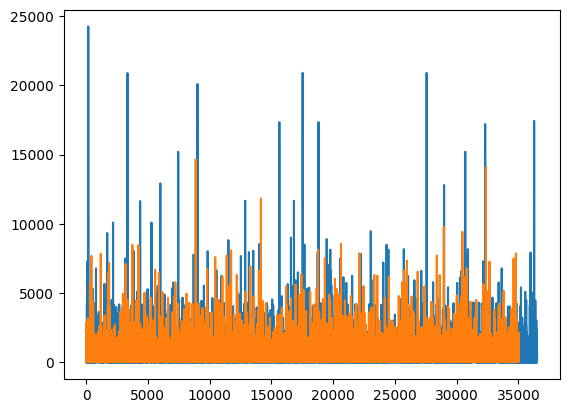

In [ ]:
plt.plot([len(txt.split()) for txt in real.text])
plt.plot([len(txt.split()) for txt in fake.text])

In [ ]:
print('Quantiles of the texts:')
print('\treal\tfake')
print(f'0.10 | {np.quantile([len(txt.split()) for txt in real.text], 0.10)}   | {np.quantile([len(txt.split()) for txt in fake.text], 0.10)}')
print(f'0.50 | {np.quantile([len(txt.split()) for txt in real.text], 0.50)}  | {np.quantile([len(txt.split()) for txt in fake.text], 0.50)}')
print(f'0.90 | {np.quantile([len(txt.split()) for txt in real.text], 0.90)}  | {np.quantile([len(txt.split()) for txt in fake.text], 0.90)}')
print(f'0.95 | {np.quantile([len(txt.split()) for txt in real.text], 0.95)} | {np.quantile([len(txt.split()) for txt in fake.text], 0.95)}')

Quantiles of the texts:
	real	fake
0.10 | 80.0   | 92.0
0.50 | 373.0  | 427.0
0.90 | 983.0  | 1181.0
0.95 | 1420.0 | 1419.0


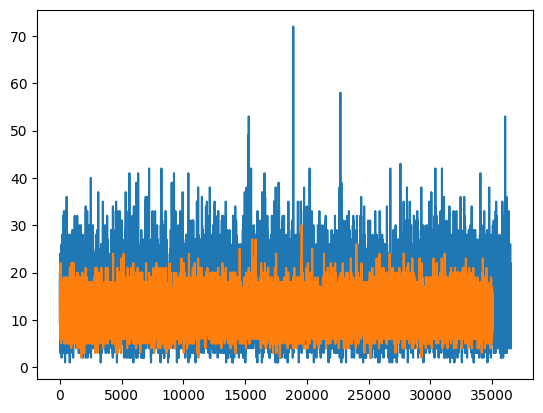

In [ ]:
plt.plot([len(txt.split()) for txt in real.title])
plt.plot([len(txt.split()) for txt in fake.title])

In [ ]:
print('Quantiles of the titles:')
print('\treal\tfake')
print(f'0.10 | {np.quantile([len(txt.split()) for txt in real.title], 0.10)}  | {np.quantile([len(txt.split()) for txt in fake.title], 0.10)}')
print(f'0.50 | {np.quantile([len(txt.split()) for txt in real.title], 0.50)} | {np.quantile([len(txt.split()) for txt in fake.title], 0.50)}')
print(f'0.90 | {np.quantile([len(txt.split()) for txt in real.title], 0.90)} | {np.quantile([len(txt.split()) for txt in fake.title], 0.90)}')
print(f'0.95 | {np.quantile([len(txt.split()) for txt in real.title], 0.95)} | {np.quantile([len(txt.split()) for txt in fake.title], 0.95)}')

Quantiles of the titles:
	real	fake
0.10 | 8.0  | 8.0
0.50 | 13.0 | 11.0
0.90 | 19.0 | 15.0
0.95 | 22.0 | 16.0


In [ ]:
# df = df[[len(txt.split()) for txt in df.text] <= np.quantile([len(txt.split()) for txt in real.text], 0.95)]

## Text cleaning

In [5]:
def remove_URL(text):
    """
        Remove URLs from a sample string
    """
    return re.sub(r"https?://\S+|www\.\S+", "", text)

def remove_html(text):
    """
        Remove the html in sample text
    """
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

def remove_non_ascii(text):
    """
        Remove non-ASCII characters 
    """
    return re.sub(r'[^\x00-\x7f]',r'', text)

def remove_special_characters(text):
    """
        Remove special special characters, including symbols, emojis, and other graphic characters
    """
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_hashtag(text):
    return re.sub(r'#([^\s]+)', r'\1', text)# hashtag symbol

def remove_punct(text):
    """
        Remove the punctuation
    """
    return re.sub(r'[]!"$%&\'()*+,/:;=#@?[\\^_`{|}~-]+', "", text) # exclude a dot
#     return text.translate(str.maketrans('', '', string.punctuation)) # include a dot

def other_clean(text):
        """
            Other manual text cleaning techniques
        """
        # Typos, slang and other
        sample_typos_slang = {
                                "w/e": "whatever",
                                "usagov": "usa government",
                                "recentlu": "recently",
                                "ph0tos": "photos",
                                "amirite": "am i right",
                                "exp0sed": "exposed",
                                "<3": "love",
                                "luv": "love",
                                "amageddon": "armageddon",
                                "trfc": "traffic",
                                "16yr": "16 year"
                                }

        # Acronyms
        sample_acronyms =  { 
                            "mh370": "malaysia airlines flight 370",
                            "okwx": "oklahoma city weather",
                            "arwx": "arkansas weather",    
                            "gawx": "georgia weather",  
                            "scwx": "south carolina weather",  
                            "cawx": "california weather",
                            "tnwx": "tennessee weather",
                            "azwx": "arizona weather",  
                            "alwx": "alabama weather",
                            "usnwsgov": "united states national weather service",
                            "2mw": "tomorrow"
                            }

        
        # Some common abbreviations 
        sample_abbr = {
                        "$" : " dollar ",
                        "€" : " euro ",
                        "4ao" : "for adults only",
                        "a.m" : "before midday",
                        "a3" : "anytime anywhere anyplace",
                        "aamof" : "as a matter of fact",
                        "acct" : "account",
                        "adih" : "another day in hell",
                        "afaic" : "as far as i am concerned",
                        "afaict" : "as far as i can tell",
                        "afaik" : "as far as i know",
                        "afair" : "as far as i remember",
                        "afk" : "away from keyboard",
                        "app" : "application",
                        "approx" : "approximately",
                        "apps" : "applications",
                        "asap" : "as soon as possible",
                        "asl" : "age, sex, location",
                        "atk" : "at the keyboard",
                        "ave." : "avenue",
                        "aymm" : "are you my mother",
                        "ayor" : "at your own risk", 
                        "b&b" : "bed and breakfast",
                        "b+b" : "bed and breakfast",
                        "b.c" : "before christ",
                        "b2b" : "business to business",
                        "b2c" : "business to customer",
                        "b4" : "before",
                        "b4n" : "bye for now",
                        "b@u" : "back at you",
                        "bae" : "before anyone else",
                        "bak" : "back at keyboard",
                        "bbbg" : "bye bye be good",
                        "bbc" : "british broadcasting corporation",
                        "bbias" : "be back in a second",
                        "bbl" : "be back later",
                        "bbs" : "be back soon",
                        "be4" : "before",
                        "bfn" : "bye for now",
                        "blvd" : "boulevard",
                        "bout" : "about",
                        "brb" : "be right back",
                        "bros" : "brothers",
                        "brt" : "be right there",
                        "bsaaw" : "big smile and a wink",
                        "btw" : "by the way",
                        "bwl" : "bursting with laughter",
                        "c/o" : "care of",
                        "cet" : "central european time",
                        "cf" : "compare",
                        "cia" : "central intelligence agency",
                        "csl" : "can not stop laughing",
                        "cu" : "see you",
                        "cul8r" : "see you later",
                        "cv" : "curriculum vitae",
                        "cwot" : "complete waste of time",
                        "cya" : "see you",
                        "cyt" : "see you tomorrow",
                        "dae" : "does anyone else",
                        "dbmib" : "do not bother me i am busy",
                        "diy" : "do it yourself",
                        "dm" : "direct message",
                        "dwh" : "during work hours",
                        "e123" : "easy as one two three",
                        "eet" : "eastern european time",
                        "eg" : "example",
                        "embm" : "early morning business meeting",
                        "encl" : "enclosed",
                        "encl." : "enclosed",
                        "etc" : "and so on",
                        "faq" : "frequently asked questions",
                        "fawc" : "for anyone who cares",
                        "fb" : "facebook",
                        "fc" : "fingers crossed",
                        "fig" : "figure",
                        "fimh" : "forever in my heart", 
                        "ft." : "feet",
                        "ft" : "featuring",
                        "ftl" : "for the loss",
                        "ftw" : "for the win",
                        "fwiw" : "for what it is worth",
                        "fyi" : "for your information",
                        "g9" : "genius",
                        "gahoy" : "get a hold of yourself",
                        "gal" : "get a life",
                        "gcse" : "general certificate of secondary education",
                        "gfn" : "gone for now",
                        "gg" : "good game",
                        "gl" : "good luck",
                        "glhf" : "good luck have fun",
                        "gmt" : "greenwich mean time",
                        "gmta" : "great minds think alike",
                        "gn" : "good night",
                        "g.o.a.t" : "greatest of all time",
                        "goat" : "greatest of all time",
                        "goi" : "get over it",
                        "gps" : "global positioning system",
                        "gr8" : "great",
                        "gratz" : "congratulations",
                        "gyal" : "girl",
                        "h&c" : "hot and cold",
                        "hp" : "horsepower",
                        "hr" : "hour",
                        "hrh" : "his royal highness",
                        "ht" : "height",
                        "ibrb" : "i will be right back",
                        "ic" : "i see",
                        "icq" : "i seek you",
                        "icymi" : "in case you missed it",
                        "idc" : "i do not care",
                        "idgadf" : "i do not give a damn fuck",
                        "idgaf" : "i do not give a fuck",
                        "idk" : "i do not know",
                        "ie" : "that is",
                        "i.e" : "that is",
                        "ifyp" : "i feel your pain",
                        "IG" : "instagram",
                        "iirc" : "if i remember correctly",
                        "ilu" : "i love you",
                        "ily" : "i love you",
                        "imho" : "in my humble opinion",
                        "imo" : "in my opinion",
                        "imu" : "i miss you",
                        "iow" : "in other words",
                        "irl" : "in real life",
                        "j4f" : "just for fun",
                        "jic" : "just in case",
                        "jk" : "just kidding",
                        "jsyk" : "just so you know",
                        "l8r" : "later",
                        "lb" : "pound",
                        "lbs" : "pounds",
                        "ldr" : "long distance relationship",
                        "lmao" : "laugh my ass off",
                        "lmfao" : "laugh my fucking ass off",
                        "lol" : "laughing out loud",
                        "ltd" : "limited",
                        "ltns" : "long time no see",
                        "m8" : "mate",
                        "mf" : "motherfucker",
                        "mfs" : "motherfuckers",
                        "mfw" : "my face when",
                        "mofo" : "motherfucker",
                        "mph" : "miles per hour",
                        "mr" : "mister",
                        "mrw" : "my reaction when",
                        "ms" : "miss",
                        "mte" : "my thoughts exactly",
                        "nagi" : "not a good idea",
                        "nbc" : "national broadcasting company",
                        "nbd" : "not big deal",
                        "nfs" : "not for sale",
                        "ngl" : "not going to lie",
                        "nhs" : "national health service",
                        "nrn" : "no reply necessary",
                        "nsfl" : "not safe for life",
                        "nsfw" : "not safe for work",
                        "nth" : "nice to have",
                        "nvr" : "never",
                        "nyc" : "new york city",
                        "oc" : "original content",
                        "og" : "original",
                        "ohp" : "overhead projector",
                        "oic" : "oh i see",
                        "omdb" : "over my dead body",
                        "omg" : "oh my god",
                        "omw" : "on my way",
                        "p.a" : "per annum",
                        "p.m" : "after midday",
                        "pm" : "prime minister",
                        "poc" : "people of color",
                        "pov" : "point of view",
                        "pp" : "pages",
                        "ppl" : "people",
                        "prw" : "parents are watching",
                        "ps" : "postscript",
                        "pt" : "point",
                        "ptb" : "please text back",
                        "pto" : "please turn over",
                        "qpsa" : "what happens", #"que pasa",
                        "ratchet" : "rude",
                        "rbtl" : "read between the lines",
                        "rlrt" : "real life retweet", 
                        "rofl" : "rolling on the floor laughing",
                        "roflol" : "rolling on the floor laughing out loud",
                        "rotflmao" : "rolling on the floor laughing my ass off",
                        "rt" : "retweet",
                        "ruok" : "are you ok",
                        "sfw" : "safe for work",
                        "sk8" : "skate",
                        "smh" : "shake my head",
                        "sq" : "square",
                        "srsly" : "seriously", 
                        "ssdd" : "same stuff different day",
                        "tbh" : "to be honest",
                        "tbs" : "tablespooful",
                        "tbsp" : "tablespooful",
                        "tfw" : "that feeling when",
                        "thks" : "thank you",
                        "tho" : "though",
                        "thx" : "thank you",
                        "tia" : "thanks in advance",
                        "til" : "today i learned",
                        "tl;dr" : "too long i did not read",
                        "tldr" : "too long i did not read",
                        "tmb" : "tweet me back",
                        "tntl" : "trying not to laugh",
                        "ttyl" : "talk to you later",
                        "u.s." : 'usa',
                        "u" : "you",
                        "u2" : "you too",
                        "u4e" : "yours for ever",
                        "utc" : "coordinated universal time",
                        "w/" : "with",
                        "w/o" : "without",
                        "w8" : "wait",
                        "wassup" : "what is up",
                        "wb" : "welcome back",
                        "wtf" : "what the fuck",
                        "wtg" : "way to go",
                        "wtpa" : "where the party at",
                        "wuf" : "where are you from",
                        "wuzup" : "what is up",
                        "wywh" : "wish you were here",
                        "yd" : "yard",
                        "ygtr" : "you got that right",
                        "ynk" : "you never know",
                        "zzz" : "sleeping bored and tired"
                        }
            
        sample_typos_slang_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_typos_slang.keys()) + r')(?!\w)')
        sample_acronyms_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_acronyms.keys()) + r')(?!\w)')
        sample_abbr_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_abbr.keys()) + r')(?!\w)')
        
        text = sample_typos_slang_pattern.sub(lambda x: sample_typos_slang[x.group()], text)
        text = sample_acronyms_pattern.sub(lambda x: sample_acronyms[x.group()], text)
        text = sample_abbr_pattern.sub(lambda x: sample_abbr[x.group()], text)
        
        return text
    
def remove_digits(text):
    """
        Remove the digits
    """
    return ''.join([i for i in text if not i.isdigit()])

def fix_spelling(text):
    return str(TextBlob(text).correct())
    
def fix_contractions(text):
    """
        Fix the contractions
    """
    return contractions.fix(text)

def transform_text(text):
    text = remove_URL(text)
    text = remove_html(text)
    text = remove_non_ascii(text)
    text = remove_special_characters(text)
    text = remove_hashtag(text)
    text = remove_punct(text)
    text = text.lower()
    text = other_clean(text)
    text = contractions.fix(text)
    text = text.lower()
    text = text.strip()
    return text

In [6]:
transform_text('Members of the #FYF911 or #FukYoFlag and #BlackLivesMatter movements ain"t called for the lynching and hanging of white people and cops. They encouraged others on a radio show Tuesday night to  turn the tide  and kill white people and cops to send a message about the killing of black people in America.One of the F***YoFlag organizers is called  Sunshine.  She has a radio blog show hosted from Texas called,  Sunshine s F***ing ')

'members of the fyf911 or fukyoflag and blacklivesmatter movements are not called for the lynching and hanging of white people and cops. they encouraged others on a radio show tuesday night to  turn the tide  and kill white people and cops to send a message about the killing of black people in america.one of the fyoflag organizers is called  sunshine.  she has a radio blog show hosted from texas called  sunshine s fing'

In [7]:
df['text2'] = df.text.apply(transform_text)
df['title2'] = df.title.apply(transform_text)

In [8]:
for i in range(29, 100):
    print(df['text'].iloc[i])
    print('-----------------')
    print(df['text2'].iloc[i])
    break

HARARE (Reuters) - Zimbabwe President Robert Mugabe arrived at a university graduation ceremony in the capital on Friday, his first public appearance since a military seizure of power that political sources say is aimed at ending his 37 years in office. Wearing a blue and yellow academic gown and mortar board hat, the 93-year-old sat in large wooden chair at the front the hall. He was greeted by ululations from the crowd as he declared the ceremony open. 
-----------------
harare reuters  zimbabwe president robert mugabe arrived at a university graduation ceremony in the capital on friday his first public appearance since a military seizure of power that political sources say is aimed at ending his 37 years in office. wearing a blue and yellow academic gown and mortar board hat the 93yearold sat in large wooden chair at the front the hall. he was greeted by ululations from the crowd as he declared the ceremony open.


# Splitting data

In [8]:
df_X, df_y = df.drop(columns=['label']), df['label']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.1, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

In [10]:
print(f'Train:      {X_train.shape} | {y_train.shape}')
print(f'Validation: {X_val.shape} | {y_val.shape}')
print(f'Test:       {X_test.shape}  | {y_test.shape}')

Train:      (51506, 4) | (51506,)
Validation: (12877, 4) | (12877,)
Test:       (7154, 4)  | (7154,)


In [11]:
print('\t\t\treal   | fake')
print(f'Train:      {sum(y_train==1)/len(y_train)} | {sum(y_train==0)/len(y_train)}')
print(f'Validation: {sum(y_val==1)/len(y_val)} | {sum(y_val==1)/len(y_val)}')
print(f'Test:       {sum(y_test==1)/len(y_test)}    | {sum(y_test==1)/len(y_test)}')

			real   | fake
Train:      0.5110860870578185 | 0.4889139129421815
Validation: 0.5119981362118506 | 0.5119981362118506
Test:       0.5020967291026    | 0.5020967291026


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
from scipy.sparse import hstack

In [ ]:
def tfidf_vectorize(data):
    new_data = data[['text2', 'title2']]
    vectorizer = TfidfVectorizer()
    text2 = vectorizer.fit_transform(new_data['text2'])
    title2 = vectorizer.fit_transform(new_data['title2'])
    return hstack([text2, title2])

def tfidf_vectorize_all(train, val, test):
    new_train = train[['text2', 'title2']]
    new_val = val[['text2', 'title2']]
    new_test = test[['text2', 'title2']]
    vectorizer_text = TfidfVectorizer()
    vectorizer_title = TfidfVectorizer()
    
    train_text2 = vectorizer_text.fit_transform(new_train['text2'])
    train_title2 = vectorizer_title.fit_transform(new_train['title2'])
    
    val_text2 = vectorizer_text.transform(new_val['text2'])
    val_title2 = vectorizer_title.transform(new_val['title2'])
    
    test_text2 = vectorizer_text.transform(new_test['text2'])
    test_title2 = vectorizer_title.transform(new_test['title2'])
    
    return (
        hstack([train_text2, train_title2]),
        hstack([val_text2, val_title2]),
        hstack([test_text2, test_title2])
    )

In [ ]:
X_train, X_val, X_test = tfidf_vectorize_all(X_train, X_val, X_test)
print(f'Train:      {X_train.shape}')
print(f'Validation: {X_val.shape}')
print(f'Test:       {X_test.shape}')

Train:      (51506, 278717)
Validation: (12877, 278717)
Test:       (7154, 278717)


In [ ]:
class CustomTfidfVectorizer(TfidfVectorizer):
    def __init__(self):
        super().__init__()

    def fit_transform(self, X, y):
        new_X = X[['text2', 'title2']]
        vectorizer = TfidfVectorizer()
        vectorized_text = super().fit_transform(new_X['text2'])
        vectorized_title = super().fit_transform(new_X['title2'])
        result = pd.DataFrame({'text2': np.array(vectorized_text),
                               'title2': np.array(vectorized_title)})
        return result

In [ ]:
np.concatenate([np.zeros((10, 5)), np.zeros((10, 5))], axis=1)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
pipe_svm = Pipeline(
    [
        ('vectorizer', CustomTfidfVectorizer()),
        ('classifier', SVC())
    ]
)

pipe_svm.fit(X_train[:100], y_train[:100])

ValueError: If using all scalar values, you must pass an index

In [ ]:
svm = SVC(verbose=True)

In [ ]:
svm.fit(X_train, y_train)

SVC(verbose=True)

In [ ]:
y_preds = svm.predict(X_test)
y_preds.shape

(7154,)

In [11]:
from sklearn.metrics import confusion_matrix,classification_report

Text(0.5, 427.9555555555555, 'Predicted label')

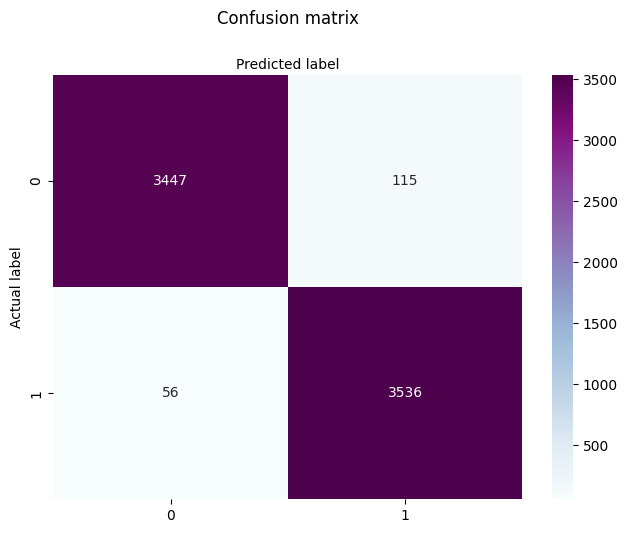

In [ ]:
cm = confusion_matrix(y_test,y_preds)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BuPu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3562
           1       0.97      0.98      0.98      3592

    accuracy                           0.98      7154
   macro avg       0.98      0.98      0.98      7154
weighted avg       0.98      0.98      0.98      7154



# test


In [16]:
def tfidf_vectorize_all_ver2(train, val, test):
    new_train = train[['text2', 'title2']]
    new_val = val[['text2', 'title2']]
    new_test = test[['text2', 'title2']]
    vectorizer_text1 = TfidfVectorizer()
    vectorizer_title1 = TfidfVectorizer()
    
    train_text2 = vectorizer_text1.fit_transform(new_train['text2'])
    train_title2 = vectorizer_title1.fit_transform(new_train['title2'])

    vectorizer_text2 = TfidfVectorizer(vocabulary=vectorizer_text1.vocabulary_)
    vectorizer_title2 = TfidfVectorizer(vocabulary=vectorizer_title1.vocabulary_)

    val_text2 = vectorizer_text2.fit_transform(new_val['text2'])
    val_title2 = vectorizer_title2.fit_transform(new_val['title2'])
    
    test_text2 = vectorizer_text2.fit_transform(new_test['text2'])
    test_title2 = vectorizer_title2.fit_transform(new_test['title2'])
    
    return (
        hstack([train_text2, train_title2]),
        hstack([val_text2, val_title2]),
        hstack([test_text2, test_title2])
    )

In [17]:
X_train, X_val, X_test = tfidf_vectorize_all_ver2(X_train, X_val, X_test)
print(f'Train:      {X_train.shape}')
print(f'Validation: {X_val.shape}')
print(f'Test:       {X_test.shape}')

Train:      (51506, 278717)
Validation: (12877, 278717)
Test:       (7154, 278717)


In [18]:
svm = SVC(verbose=True)

In [19]:
svm.fit(X_train, y_train)

SVC(verbose=True)

In [20]:
y_preds = svm.predict(X_test)
y_preds.shape

(7154,)

Text(0.5, 427.9555555555555, 'Predicted label')

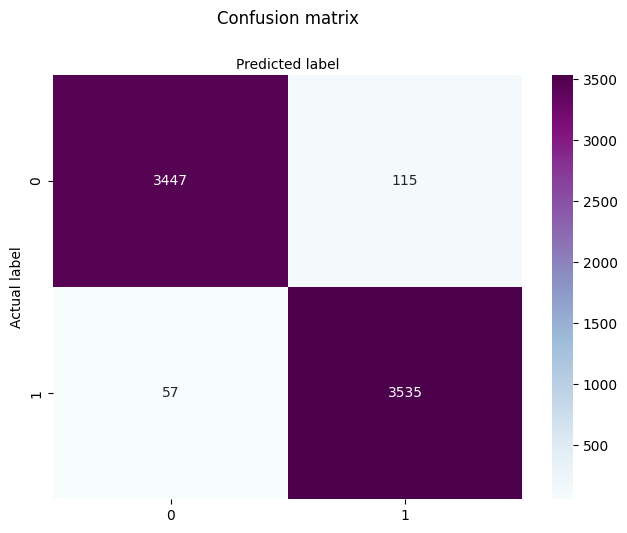

In [22]:
cm = confusion_matrix(y_test,y_preds)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BuPu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [23]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3562
           1       0.97      0.98      0.98      3592

    accuracy                           0.98      7154
   macro avg       0.98      0.98      0.98      7154
weighted avg       0.98      0.98      0.98      7154



In [26]:
from sklearn.metrics import accuracy_score, f1_score

In [27]:
accuracy_score(y_test,y_preds)

0.9759575062901873

In [28]:
f1_score(y_test,y_preds)

0.976249654791494

# test 2

In [13]:
df_X, df_y = df.drop(columns=['label']), df['label']

In [14]:
vectorizer_text_ = TfidfVectorizer()
vectorizer_title_ = TfidfVectorizer()
text2_ = vectorizer_text_.fit_transform(df_X['text2'])
title2_ = vectorizer_title_.fit_transform(df_X['title2'])
df_X_ = hstack([text2_, title2_])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_X_, df_y, test_size=0.1, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

In [16]:
print(f'Train:      {X_train.shape} | {y_train.shape}')
print(f'Validation: {X_val.shape} | {y_val.shape}')
print(f'Test:       {X_test.shape}  | {y_test.shape}')

Train:      (51506, 325098) | (51506,)
Validation: (12877, 325098) | (12877,)
Test:       (7154, 325098)  | (7154,)


In [37]:
svm_ = SVC(verbose=True)

In [38]:
svm_.fit(X_train, y_train)

SVC(verbose=True)

In [42]:
y_preds = svm_.predict(X_val)
y_preds.shape

(12877,)

In [44]:
accuracy_score(y_val,y_preds)

0.9742952551060029

In [47]:
f1_score(y_val,y_preds)

0.9751221345358887

Text(0.5, 427.9555555555555, 'Predicted label')

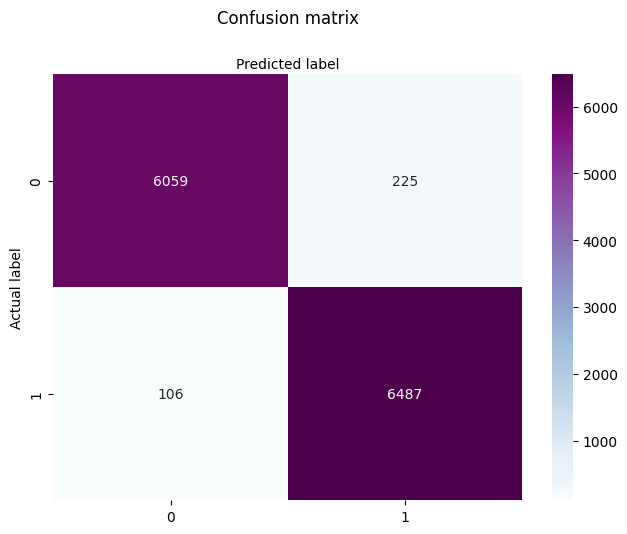

In [46]:
cm = confusion_matrix(y_val,y_preds)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BuPu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [48]:
from sklearn.ensemble import RandomForestClassifier

In [49]:
rfc = RandomForestClassifier()

In [50]:
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [51]:
y_preds = rfc.predict(X_val)

Text(0.5, 427.9555555555555, 'Predicted label')

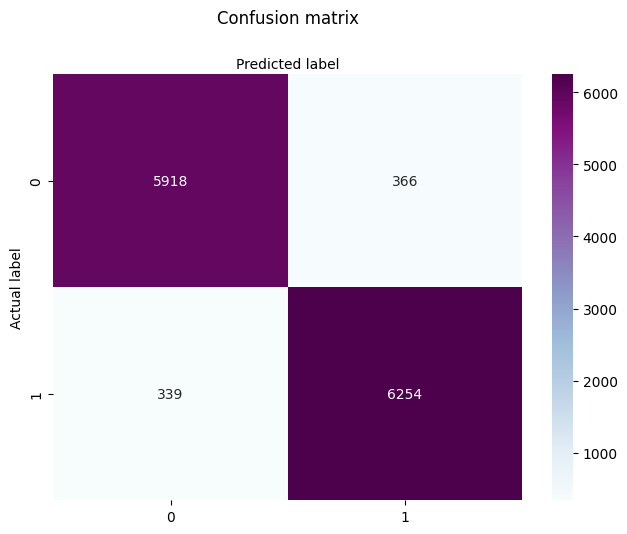

In [52]:
cm = confusion_matrix(y_val,y_preds)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BuPu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [54]:
print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      6284
           1       0.94      0.95      0.95      6593

    accuracy                           0.95     12877
   macro avg       0.95      0.95      0.95     12877
weighted avg       0.95      0.95      0.95     12877



In [12]:
from sklearn.linear_model import LogisticRegression

In [56]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [57]:
y_preds = lr.predict(X_val)

Text(0.5, 427.9555555555555, 'Predicted label')

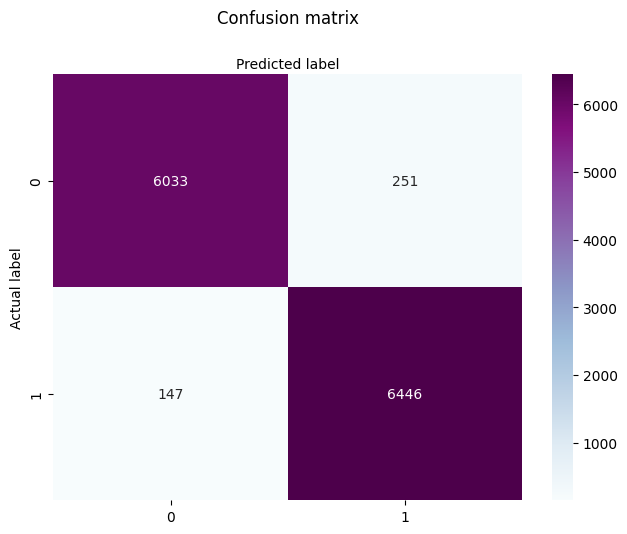

In [58]:
cm = confusion_matrix(y_val,y_preds)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BuPu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [59]:
print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      6284
           1       0.96      0.98      0.97      6593

    accuracy                           0.97     12877
   macro avg       0.97      0.97      0.97     12877
weighted avg       0.97      0.97      0.97     12877



In [17]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import optuna

In [21]:
lr = LogisticRegression()

In [19]:
param_distributions = {
    'penalty': optuna.distributions.CategoricalDistribution(['l1', 'l2']),
    # 'tol': optuna.distributions.FloatDistribution(1e-5, 1e-3, log=True),
    'C': optuna.distributions.FloatDistribution(1e-10, 1e10, log=True),
    'solver': optuna.distributions.CategoricalDistribution(['liblinear', 'saga']),
    # 'random_state': optuna.distributions.IntDistribution(42, 42),
    # 'max_iter': optuna.distributions.IntDistribution(50, 150, step=10),
}

In [22]:
optuna_search = optuna.integration.OptunaSearchCV(lr, param_distributions, random_state=42)

<ipython-input-22-a617f72bf59a>:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(lr, param_distributions, random_state=42)


In [23]:
optuna_search.fit(X_train, y_train)

[I 2023-04-06 10:10:19,713] A new study created in memory with name: no-name-25574041-488f-4f27-a223-ee7ecc48516a
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-04-06 10

OptunaSearchCV(estimator=LogisticRegression(),
               param_distributions={'C': FloatDistribution(high=10000000000.0, log=True, low=1e-10, step=None),
                                    'penalty': CategoricalDistribution(choices=('l1', 'l2')),
                                    'random_state': IntDistribution(high=42, log=False, low=42, step=1),
                                    'solver': CategoricalDistribution(choices=('liblinear', 'saga'))},
               random_state=42)

In [28]:
y_preds = optuna_search.best_estimator_.predict(X_test)

Text(0.5, 427.9555555555555, 'Predicted label')

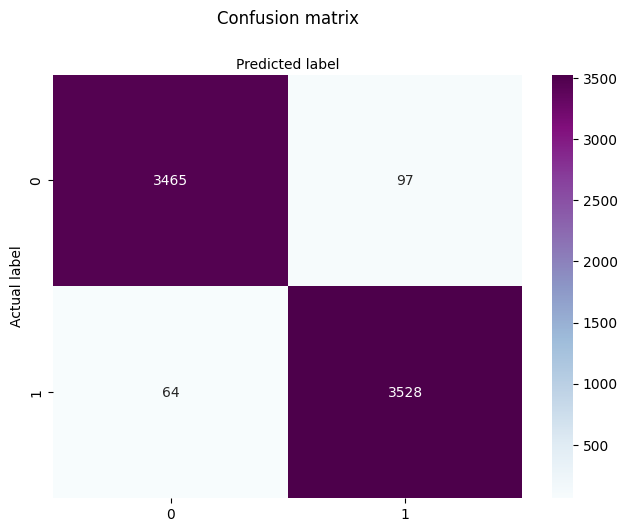

In [29]:
cm = confusion_matrix(y_test,y_preds)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BuPu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [30]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3562
           1       0.97      0.98      0.98      3592

    accuracy                           0.98      7154
   macro avg       0.98      0.98      0.98      7154
weighted avg       0.98      0.98      0.98      7154



In [38]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [35]:
accuracy_score(y_test, y_preds)

0.9774951076320939

In [36]:
f1_score(y_test, y_preds)

0.9776915615906886

In [39]:
roc_auc_score(y_test, y_preds)

0.9774753679334824

In [37]:
df_X, df_y = df['title'], df['label']

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
df_X = tfidf_vectorizer.fit_transform

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.1, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)